In [37]:
import pathlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt, ticker, patheffects, lines

plt.style.use("minimal.mplstyle")

FIGURE_SIZE = (5, 3.5)
SPACEBAR = "_"
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower() + SPACEBAR

In [38]:
DATA_PATH = pathlib.Path("../data/behavioural")
EXPORT_PATH = pathlib.Path("../showcase")

selected_participant = "a"
LOG_FILENAME = f"group13_{selected_participant}.csv"

In [39]:
def load_data():
    global results
    results = pd.read_csv(DATA_PATH.joinpath(LOG_FILENAME))
    results["timestamp"] = pd.to_datetime(results["timestamp"])
    results["response_time"] *= 1000
    results[["response", "target_response"]] = results[["response", "target_response"]].replace("space", SPACEBAR)
    results["keypress_correct"] = results["response"] == results["target_response"] 
    results["progressed_to_next"] = results["feedback"] == "positive"
    results["session_cursor_position"] = results.groupby("session")["progressed_to_next"].cumsum() 
    results["session_correct_keypresses"] = results.groupby("session")["keypress_correct"].cumsum()

load_data()
results.sample(5)

,session,block,trial,cursor_position,timestamp,response_time,target_response,response,feedback,condition,keypress_correct,progressed_to_next,session_cursor_position,session_correct_keypresses
2195,1,9,93,91,2024-02-28 14:09:10.052202,58.5079,_,_,positive,control,True,True,2019,2026
4353,1,17,179,163,2024-02-28 14:14:54.715858,58.5212,g,g,positive,control,True,True,3988,3994
879,1,4,103,92,2024-02-28 14:05:30.499947,107.6702,_,_,positive,control,True,True,811,817
3248,1,13,118,106,2024-02-28 14:11:50.635723,42.6971,u,u,positive,control,True,True,2992,2997
2092,1,8,241,220,2024-02-28 14:08:52.388346,81.5902,n,d,negative,control,False,False,1917,1926


In [40]:
print(f"""Took {len(results)} attempts to type {len(results[results["progressed_to_next"]])} characters ({len(results[results["progressed_to_next"]]) / len(results):.1%} hit-rate)""")
print(f"""Typed correctly {len(results[results["keypress_correct"]])} times in {results["response_time"].sum() / 1000:.1f} seconds ({results["response_time"].sum() / len(results[results["keypress_correct"]]):.1f} ms/char)""")

Took 5495 attempts to type 5024 characters (91.4% hit-rate)
Typed correctly 5034 times in 739.9 seconds (147.0 ms/char)


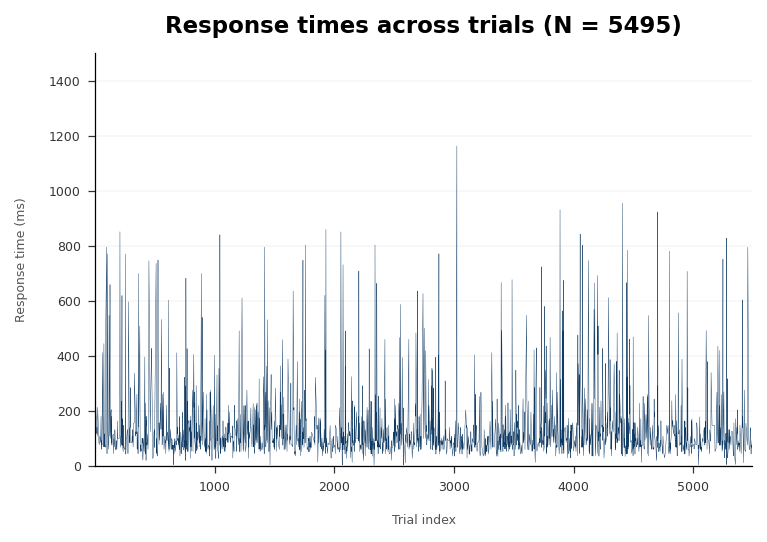

In [41]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

downscaled = results.sample(min(len(results), 2000)).sort_index()
plt.plot(
    downscaled.index, 
    downscaled["response_time"],
    linewidth = 0.2,
)
plt.title(f"Response times across trials (N = {len(results)})")
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.ylim((0, 1500))
plt.show()

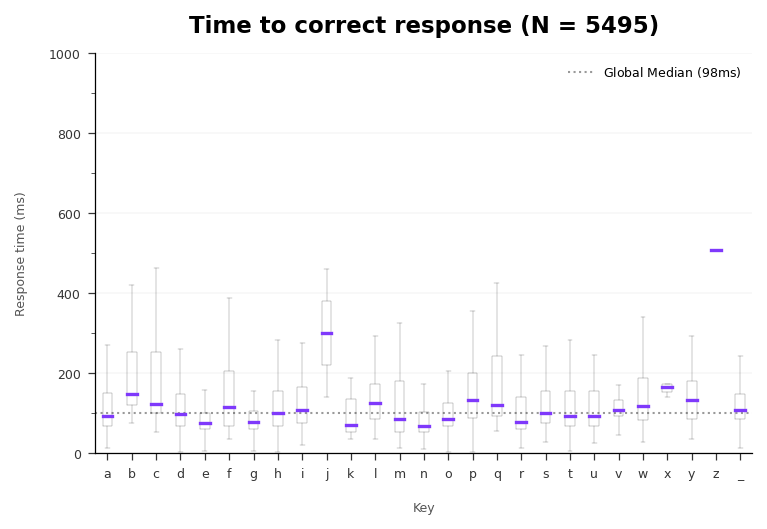

In [42]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
time_to_type = results.groupby(["session", "block", "cursor_position", "target_response"])["response_time"].sum().reset_index()

for key, data in time_to_type.groupby("target_response"):
    outlines_alpha = 0.5
    plt.boxplot(
        data["response_time"],
        positions=[ord(ALPHABET[0]) + len(ALPHABET) - 1] if key == SPACEBAR else [ord(key)],
        widths = 0.4,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = time_to_type["response_time"].median(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Median (${time_to_type["response_time"].median():.0f}$ms)"""
)
plt.legend(loc = "upper right")
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(results)})")
plt.xlabel("Key")
plt.ylabel("Response time (ms)")
plt.xticks(range(ord(ALPHABET[0]), ord(ALPHABET[0]) + len(ALPHABET)), ALPHABET)
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.show()
# plt.savefig(EXPORT_PATH.joinpath("relative_difficulty_per_key.png"), dpi = 300)

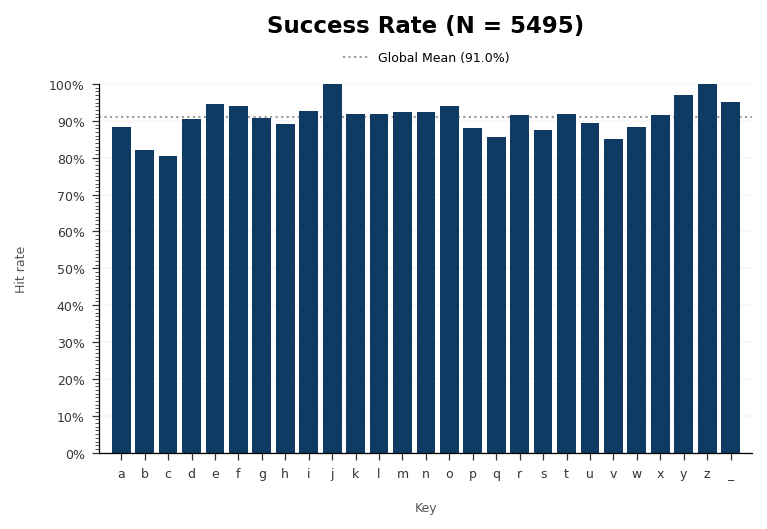

In [43]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
succes_rates = results.groupby("target_response").apply(lambda where_target: (where_target["response"] == where_target.name).mean())
# 1 - results[results["response"] != results["target_response"]]["response"].value_counts(normalize = True)

plt.bar(
    succes_rates.index.to_series().apply(lambda key: ord(ALPHABET[0]) + len(ALPHABET) - 1 if key == "_" else ord(key)), 
    succes_rates,
)

plt.axhline(
    y = succes_rates.mean(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Mean ({succes_rates.mean():.1%})"""
)
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.12))
plt.title(f"Success Rate (N = {len(results)})", pad = 25)
plt.suptitle("")
plt.xlabel("Key")
plt.ylabel("Hit rate")
plt.xticks(range(ord(ALPHABET[0]), ord(ALPHABET[0]) + len(ALPHABET)), ALPHABET)
plt.margins(x = 0.02)
plt.ylim((0, 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.show()
# plt.savefig(EXPORT_PATH.joinpath("hit_rate_per_key.png"), dpi = 300)

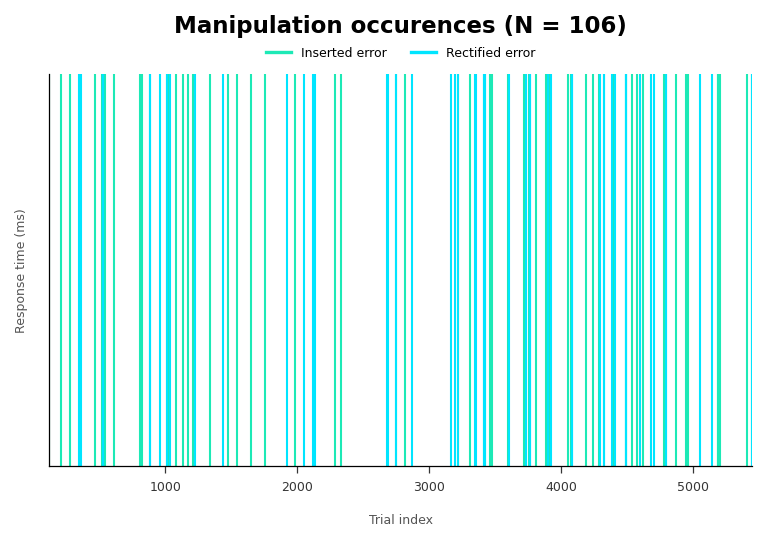

In [44]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

inserted_error_trials = results[(results["response"] == results["target_response"]) & (results["feedback"] == "negative")]
plt.plot([], [], color = "C3", label = "Inserted error")
for idx in inserted_error_trials.index:
    plt.axvline(idx, color = "C3", linewidth = 1)
rectified_error_trials = results[(results["response"] != results["target_response"]) & (results["feedback"] == "positive")]
plt.plot([], [], color = "C5", label = "Rectified error")
for idx in rectified_error_trials.index:
    plt.axvline(idx, color = "C5", linewidth = 1)

plt.title(f"Manipulation occurences (N = {len(inserted_error_trials) + len(rectified_error_trials)})", pad = 20)
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.yticks([])
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
plt.show()

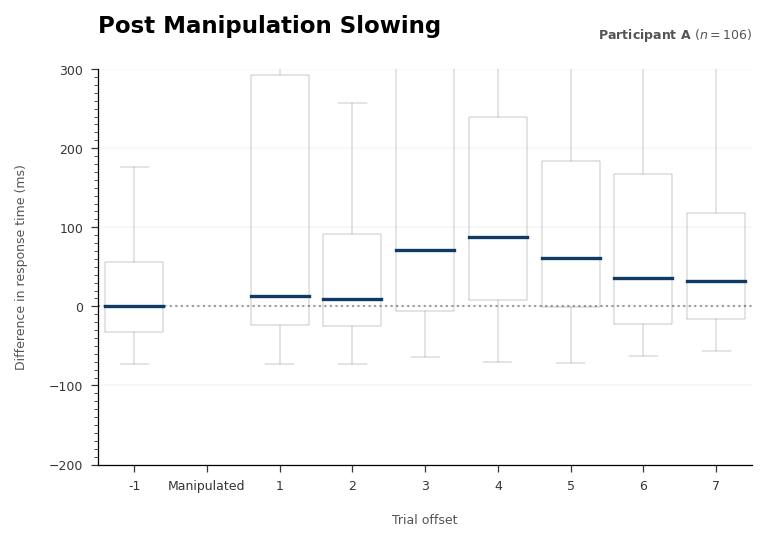

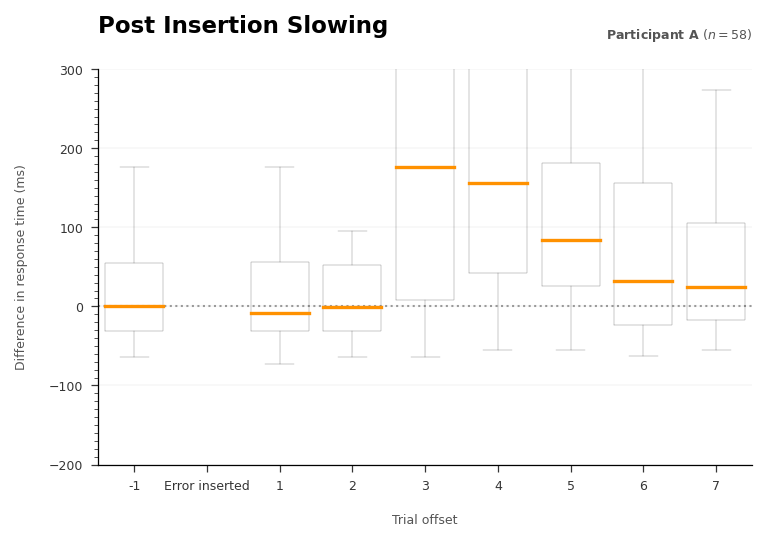

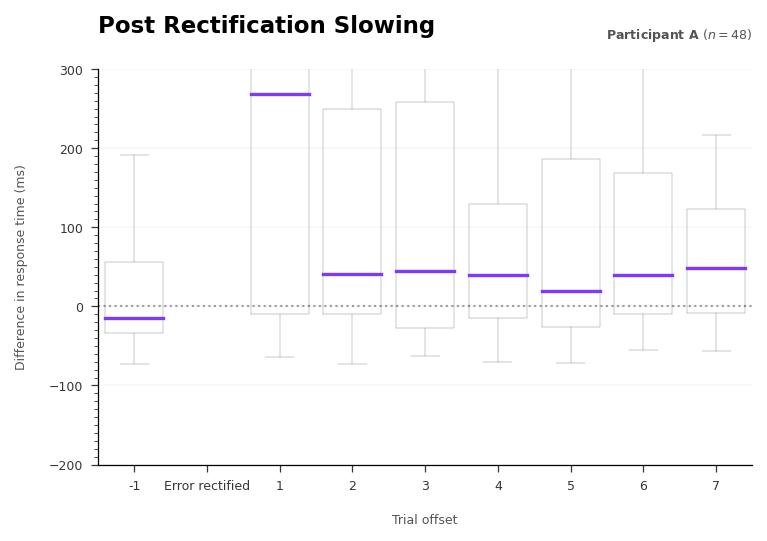

In [45]:
manipulated = results[results["condition"] != "control"]
immediately_preceding_manipulations = results["response_time"].loc[[trial_idx - 1 for trial_idx in manipulated.index]]

conditions = {
    "Post Manipulation Slowing": "manipulated",
    "Post Insertion Slowing": "error inserted",
    "Post Rectification Slowing": "error rectified",
}

for condition_index, (title, condition) in enumerate(conditions.items()):
    plt.figure(figsize=FIGURE_SIZE)
    trials = results[results["condition"] != "control"] if condition == "manipulated" else results[results["condition"] == condition]
    offset_range = range(-1, 8)
    for trial_offset in offset_range:
        if trial_offset == 0:
            continue
        response_times = results["response_time"].loc[[trial_idx + trial_offset for trial_idx in trials.index if trial_idx + trial_offset in results.index.values]]
        outlines_alpha = 0.5
        plt.boxplot(
            response_times - immediately_preceding_manipulations.median(),
            positions=[trial_offset],
            widths = 0.8,
            boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
            medianprops = dict(linewidth = 1.6, color = f"C{condition_index}"),
        )
    plt.axhline(
        y = 0,
        linestyle = ":",
        linewidth = 1,
        color = "black",
        alpha = 0.4,
        zorder = -1,
    )
    plt.xticks(offset_range, [condition.capitalize() if offset == 0 else offset for offset in offset_range])
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(10))

    plt.title(title, x = 0, ha = "left", y = 1.04)
    plt.annotate(
        f"Participant {selected_participant.upper()} $(n = {len(trials)})$",
        xy = (1, 0.98),
        xycoords = ("axes fraction", "figure fraction"),
        fontweight = "bold",
        color = "#545454",
        ha = "right",
        va = "top"
    )
    plt.xlabel("Trial offset")
    plt.ylabel("Difference in response time (ms)")
    plt.ylim((-200, 300))
    plt.show()
    # plt.savefig(EXPORT_PATH.joinpath(f"{title}.png"), dpi = 300)


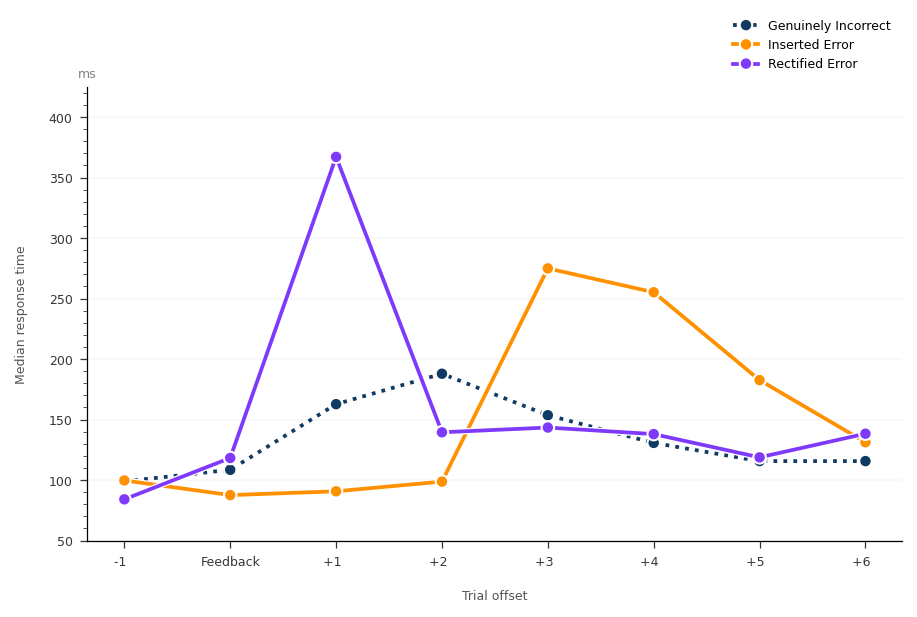

In [46]:
conditions = {
    "Genuinely Incorrect": "incorrect",
    "Inserted Error": "error inserted",
    "Rectified Error": "error rectified",
}

fig, ax = plt.subplots(figsize = (6, 4))

ax.annotate(
    "ms",
    xy = (0, 1.02),
    xycoords = "axes fraction",
    ha = "center",
    alpha = 0.5,
)

for condition_index, (title, condition) in enumerate(conditions.items()):
    trials = results[~results["keypress_correct"]] if condition == "incorrect" else results[results["condition"] == condition]
    offset_range = range(-1, 7)
    res = []
    for trial_offset in offset_range:
        response_times = results.loc[[trial_idx + trial_offset for trial_idx in trials.index if trial_idx in results.index]]["response_time"]
        params = stats.lognorm.fit(response_times)
        res.append(dict(
            offset = trial_offset, 
            mean = response_times.mean(),
            median = response_times.median(),
            lower = stats.lognorm.isf(0.25, *params),
            upper = stats.lognorm.isf(0.75, *params),
        ))

    res = pd.DataFrame.from_records(res)
    
    ax.plot(
        res["offset"],
        res["median"],
        marker = "o",
        markersize = 4,
        linewidth = 1.8,
        color = f"C{condition_index}",
        linestyle = "dotted" if condition == "incorrect" else "solid",
        path_effects = [patheffects.Stroke(linewidth = 3, foreground = "white"), patheffects.Normal()],
        label = title,
    )

    ax.xaxis.set_major_formatter(lambda val, idx: "Feedback" if val == 0 else f"{val:+.0f}  ")
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.margins(x = 0.05)

    ax.set_xlabel("Trial offset")
    ax.set_ylabel("Median response time")
    ax.set_ylim((50, 425))
    # ax.legend(
    #     handles = [lines.Line2D([0], [0], color="white")] * 3,
    #     labels = [""] * 3,
    #     loc = "lower right", 
    #     bbox_to_anchor = (1, 1.01),
    # )
    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )
plt.show()

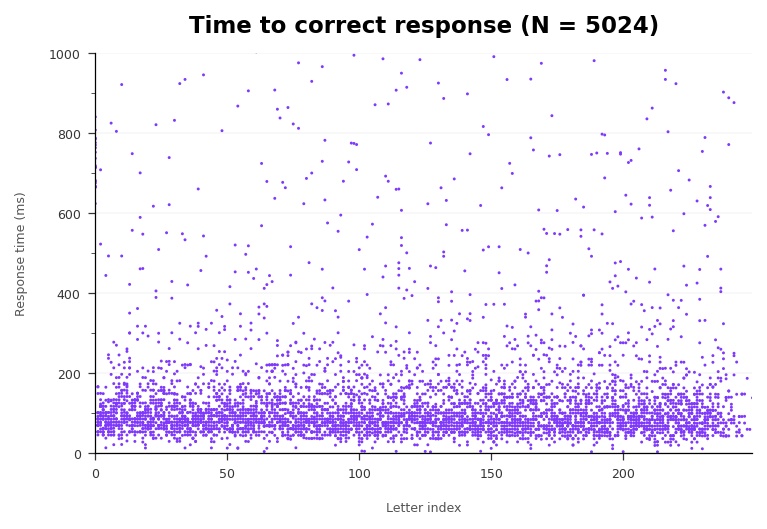

In [47]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(
    time_to_type["cursor_position"], 
    time_to_type["response_time"],
    marker = "o",
    s = 2,
    color = "C2",
    edgecolor = "none",
)
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(time_to_type)})")
plt.xlabel("Letter index")
plt.ylabel("Response time (ms)")
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.show()